## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Redes convolucionales

### Nombres:

- Nelson Aldana
- Diego Ojeda
- Daniel Rojas


### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

En este cuadernos estudiaremos las redes profundas convolucionales (CNN). Implementaremos nuestra propia red utilizando la biblioteca (API) Keras (https://keras.io/). 

Probaremos nuestros modelos más complejos de *deep learning* para la detección automática de frailejones sobre imagenes aereas del páramo e intentaremos mejorar los resultados que obtuvimos con nuestras redes más sencillas. Recordemos que hasta ahora hemos logrado unos resultados preliminares con un *accuracy* de validación de 0.86, utilizando una red sencilla de 5 neuronas.

Importemos algunos de los paquetes que vamos a utilizar:

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from ImportImagenesRGB import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from prettytable import PrettyTable
import datetime

import keras
from keras.models import Sequential, load_model
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.layers import SpatialDropout2D

from numpy.random import seed
seed(1)

In [2]:
X,Y = import_imagenes_RGB()

print(X.shape, Y.shape, X[0,0,0])

(250, 70, 70, 3) (1, 250) [0.58823529 0.5372549  0.40392157]


**Salida esperada:**

(250, 70, 70, 3) (1, 250) [0.58823529 0.5372549  0.40392157]


## 1. Redes convolucionales

Las redes convolucionales (CNN: *Convolutional Neural Nets*) es un tipo de red neuronal (profunda) que suele usarse para el tratamiento de imagenes y la vision computacional, pero que también sirve para otras tareas como el procesamiento de datos secuenciales, lenguage natural, datos geo-referenciados o datos estructurados que guarden ciertas correlaciones entre sí (ver por ejemplo W. Kim (2014) Convolutional Neural Networks for Sentence Classification). 

Se les concoce por ser invariantes a translaciones, de tal manera que con su arquitectura producen exactamente la misma respuesta ante diferentes traslaciones (como por ejemplo rotaciones) que se le aplique a los datos de entrada. 

Un aspecto importante para entender las CNN de la mano con el tema que hemos visto hasta ahora en el curso, consiste en entender que los pesos y sesgos de una *capa convolucional* son **filtros** que extraen patrones particulares de los datos de entrada. Luego de la extracción de patrones, la red cuenta con capas densamente conectadas donde distintas neuronas pueden compartir el mismo filtro. 

Veamos:
https://medium.com/analytics-vidhya/deep-learning-methods-1700548a3093

Entonces, las CNN se pueden entender como versiones regularizadas de las redes multi-capa *densamente conectadas* (donde cada neurona en una capa está conectada con todas las demás neuronas de la siguiente capa). Este tipo de conexión *densa* facilita el *sobre-ajuste* a los datos de muestra con los que se construyen los mdoelos. Así, las CNN se enfocan en construir patrones más complejos pero más simples, encontrando *areas* de atención en las que enfocarse, haciendo uso de filtros y de **convoluciones** (formalmente hablando, una convolución corresponde con la operación matemática de la correlación cruzada). 

Veamos un ejemplo con un filtro de $3\times 3$ y una *stride* de 1:


$$ Imagen = \begin{bmatrix}
    1  & 1  & 1 & 0 & 0\\
    0 & 1 & 1 & 1 & 0 \\
    0  & 0 & 1  & 1 & 1 \\
    0 & 0 & 1 & 1 & 0 \\
    0  & 1 & 1  & 0 & 0
\end{bmatrix};\;\;\; Filtro = \begin{bmatrix}
    1  & 0  & 1\\
    0  & 1 & 0 \\
    1  & 0 & 1 
\end{bmatrix}; \;\;\; Patron =\begin{bmatrix}
    4  & 3  & 4\\
    2  & 4 & 3 \\
    2  & 3 & 4 
\end{bmatrix}$$

Para obtener el nuevo patrón convolucionado, resolvemos la operación $\otimes_1$ denotando una convolución con un *stride* de 1, o una *ventana móvil de 1 en 1*, tal que $Patron = Imagen \otimes_1 Filtro$.



Además de la operación convolucional, tras una capa convolucional le suele seguir un filtro de agregación conocido como **pooling**. Este filtro también toma ventanas móviles y resume los valores dentro de su rango de acuerdo con una operación de agregación específica.

Por ejmplo, un *Max-pooling* consiste en tomar el máximo dentro de cada ventana. Si tomamos un filtro de Max-pooling de tamaño $2\times 2$ y un *stride* de 2, y lo aplicamos sbre el patrón $P$, obtenemos:

$$ P = \begin{bmatrix}
    5  & 4  & 6 & 3\\
    3  & 9 & 4 & 5 \\
    8  & 1 & 7  & 9  \\
    0 & 2 & 8 & 0  
\end{bmatrix}\;\;\; $$

$$ MaxPool_{2\times 2}^{stride=2}(P) = \begin{bmatrix}
    9  & 6\\
    8  & 9
\end{bmatrix}$$


La gran ventaja de las CNN es que aprenden de manera automática (sin necesidad de conocimiento previo) los filtros que de otro modo habría que especificar explícita o manualmente. 

Especifiquemos a continuación la arquitectura de nuestra CNN, donde vamos a hacer uso de una técnica de **Drop-out** antes de la capa de salida. Esta técnica elimina aleatoriamente y de manera temporal (en cada iteración) un número de neuronas determinado (por una tasa de eliminación o *drop-out*), con el fin de que el modelo no recaiga demasidado en ciertas neuronas y generalize de la mejor manera la función a estimar :

In [3]:
#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Arquitectura de la red
model = Sequential()  
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dropout(rate=0.2, seed=1))   
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()

### Optimizador de Adam

Vamos a implementar la red convolucional con la arquitectura especificada arriba haciendo uso del método de optimización estocástica de **Adam** (Kingma & Ba (2015)). El término *Adam* se debe a *Adaptive Moment Estimation*, y se puede entender como una revisión al método de RMSProp. Bajo Adam, se utilizan promedios móviles tanto de los gradientes como de sus segundos momentos.  De esta manera, se tiene que 

$$ u(\theta) = \rho_1 u(\theta_{viejo}) + (1-\rho_1) \frac{\partial J (\hat \theta_{viejo}; x^{(i)}, y^{(i)})}{ \partial \hat \theta_{viejo} }  $$

$$ v(\theta) = \rho_2 v(\theta_{viejo}) + (1-\rho_2) \biggr( \frac{\partial J (\hat \theta_{viejo}; x^{(i)}, y^{(i)})}{ \partial \hat \theta_{viejo} } \biggl)^2  $$

donde

$$ \hat u = \frac{u(\theta)}{1-\rho_1^t} $$

$$ \hat v = \frac{v(\theta)}{1-\rho_2^t} $$

De tal manera que la actualización de los parámetros se lleva a cabo mediante:

$$ \hat \theta_{nuevo} = \hat \theta_{viejo} - \alpha \frac{\hat u}{\sqrt{\hat v}+\varepsilon}$$ 

donde $\varepsilon$ es un escalar muy pequeño (infinitesimal) que previene la división por cero, $\rho_1, \rho_2$ son respectivamente  los factores de memoria sobre el primer y segundo momento de los gradientes. 

In [4]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])
Acc_E = []
Acc_V = []
Acc_P = []

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('Best_Model_CNN.tf')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' y accu_v='+str(accu_v))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])
    
    # Exactitud media
    Acc_E.append(accu_e)
    Acc_V.append(accu_v)
    Acc_P.append(accu_p)

print(x)

print('Accuracies de Entrenamiento: '+str(np.round(np.mean(Acc_E),3))
      +'; Validacion1: '+str(np.round(np.mean(Acc_V),3))+ '; Validacion2: '+str(np.round(np.mean(Acc_P),3)))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Best_Model_CNN.tf\assets
Epoca= 17 y accu_v=0.8648648858070374
INFO:tensorflow:Assets written to: Best_Model_CNN.tf\assets
Epoca= 57 y accu_v=0.8918918967247009
INFO:tensorflow:Assets written to: Best_Model_CNN.tf\assets
Epoca= 89 y accu_v=0.8648648858070374
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.8649 | 0.8684 |   17  |
|  1.0   | 0.8919 | 0.8684 |   57  |
| 0.9943 | 0.8649 | 0.9474 |   89  |
+--------+--------+--------+-------+
Accuracies de Entrenamiento: 0.998; Validacion1: 0.874; Validacion2: 0.895


### Pregunta 3.1

Qué puede observar sobre estos resultados?

Podemos observar que se llega a valores de Accuracy superiores (90 %) a los de la red densamente conectada (86 %), con menos epocas, lo que nos indica que el optimizador ADAM presenta resultados satisfactorios para esta arquitectura y estos tipos de datos.

Visualicemos el aprendizaje del mejor modelo:

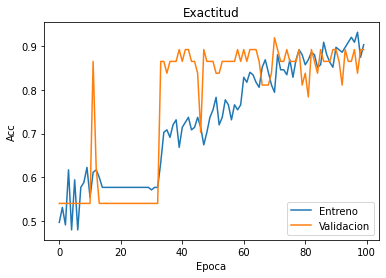

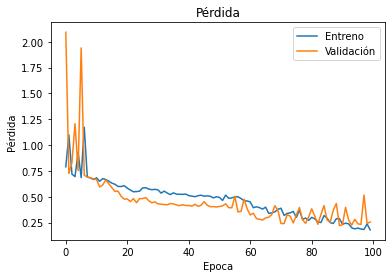

In [11]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Cargamos el mejor modelo y confirmamos el desempeño del modelo sobre todo el conjunto de datos:

In [12]:
# red convolucional
model_3 = load_model('Best_Model_CNN.tf')

model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

Veamos el desempeño del mejor modelo sobre todo el conjunto de datos:

In [13]:
Y_pred = model_3.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[139,   6],
       [  2, 103]], dtype=int64)

**Salida esperada:**
    
<table style="width:20%">
    <tr>
       <td> 134 </td>
       <td> 11 </td>
    </tr>
    <tr>
       <td> 4 </td>
       <td> 101 </td>
    </tr>

</table>

### Ejercicio 1.1

Intente hacer que el optimizador Adam converja en todas las repeticiones. 


In [16]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])
Acc_E = []
Acc_V = []
Acc_P = []

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.8, beta_2=0.9)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('Best_Model_CNN_Conv.tf')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' y accu_v='+str(accu_v))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])
    
    # Exactitud media
    Acc_E.append(accu_e)
    Acc_V.append(accu_v)
    Acc_P.append(accu_p)

print(x)

print('Accuracies de Entrenamiento: '+str(np.round(np.mean(Acc_E),3))
      +'; Validacion1: '+str(np.round(np.mean(Acc_V),3))+ '; Validacion2: '+str(np.round(np.mean(Acc_P),3)))

INFO:tensorflow:Assets written to: Best_Model_CNN_Conv.tf\assets
Epoca= 11 y accu_v=0.9189189076423645
INFO:tensorflow:Assets written to: Best_Model_CNN_Conv.tf\assets
Epoca= 24 y accu_v=0.8918918967247009
INFO:tensorflow:Assets written to: Best_Model_CNN_Conv.tf\assets
Epoca= 24 y accu_v=0.8648648858070374
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.9189 | 0.8947 |   11  |
|  1.0   | 0.8919 | 0.7895 |   24  |
|  1.0   | 0.8649 | 0.9211 |   24  |
+--------+--------+--------+-------+
Accuracies de Entrenamiento: 1.0; Validacion1: 0.892; Validacion2: 0.868


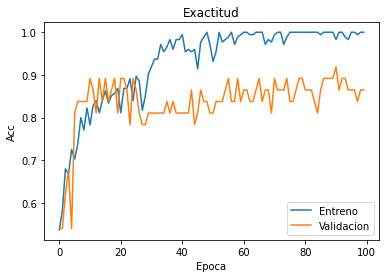

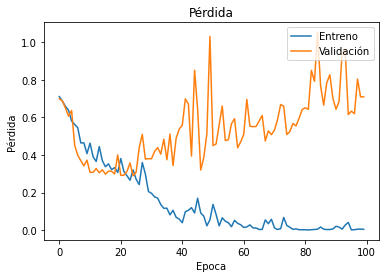

In [18]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

### Ejercicio 1.2

Compare los resultados al utilizar otros algoritmos de aprendizaje como RMSprop o el mismo SGD

* RMSprop

Inicio Init=L2=0.01:2020-09-22 19:08:00.149940
Epoca= 130 , accu_v1=0.8918918967247009 , accu_v2=0.8684210777282715
Fin Init= L2=0.01:2020-09-22 19:12:26.541750


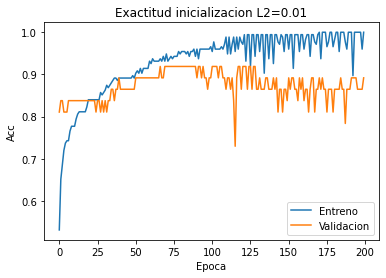

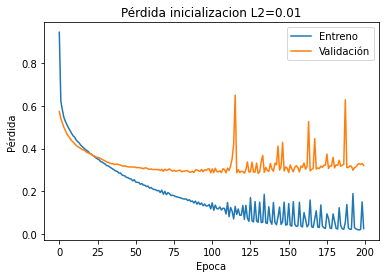

+--------+--------+--------+-------+---------+
| Exac_E | Exac_V | Exac_P | Epoca |   Init  |
+--------+--------+--------+-------+---------+
|  1.0   | 0.8919 | 0.8684 |  130  | L2=0.01 |
+--------+--------+--------+-------+---------+


In [19]:
model = Sequential()  
model.add(Flatten(input_shape=X.shape[1:]))
model.add(Dense(700, activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))  
model.add(Dense(400, activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(800, activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(400, activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(40, activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros',
                kernel_regularizer=keras.regularizers.l2(0.001))) 
    
# Guardamos la arquitectura de red
config_best = model.get_config()

# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca", "Init"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=200

# Definimos los parametros del RMSProp
rmsprop = keras.optimizers.RMSprop(lr=0.000008, rho=0.9)

# implementamos 2 repeticiones, una con inicializacion aleatoria Normal y otra con He

model_fit = Sequential.from_config(config_best)
Regularization = "L2=0.01"
tiempo0 = datetime.datetime.now()
print('Inicio Init=' +str(Regularization)+':' +str(tiempo0))

# Partimos los datos en entrenamiento y doble validación
CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = 8)
CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = 8)

# Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
model_fit.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

# Ajustamos el modelo
history=model_fit.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)  

# Encontramos el mejor modelo en validación
min_err=np.min(history.history['val_loss'])
best_epoc=np.where(history.history['val_loss'] == min_err)[0] 

# Conseguimos el mejor modelo de acuerdo con su desempeño en la primera validación
model_fit.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)

# Calculamos las metricas
train_metrics = model_fit.evaluate(x=CE_x, y=CE_y, verbose=0)
valid_metrics = model_fit.evaluate(x=CV_x, y=CV_y, verbose=0)
test_metrics = model_fit.evaluate(x=CP_x, y=CP_y, verbose=0)

# Guardamos las métricas de desempeño
accu_e = train_metrics[1]
loss_e = train_metrics[0]
accu_v = valid_metrics[1]
loss_v = valid_metrics[0]
accu_p = test_metrics[1]
loss_p = test_metrics[0]

pathr =('Modelo_Fit_Imagenes.h5')
model_fit.save(pathr) 
err_p = loss_p

x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0], Regularization])

# Imprimimos el desempeño para cada inicializacion y el tiempo en completar las iteraciones
print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
tiempo1 = datetime.datetime.now()
print('Fin Init= ' +str(Regularization)+':' +str(tiempo1))

# Graficamos el desempeño del modelo
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud inicializacion ' +str(Regularization))  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida inicializacion ' +str(Regularization))  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

print(x)

* SGD

In [21]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])
Acc_E = []
Acc_V = []
Acc_P = []

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=1000

# Definimos los parametros del SGD
sgd = SGD(lr=0.01, momentum=0.001)

# junto con la inicialización He Normal
initializer_He = keras.initializers.he_normal(seed=1)

# inicializamos el error para guardar el mejor modelo
err_p = 999
  
# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Especificamos la arquitectura de la red 
    model = Sequential()  
    model.add(Flatten(input_shape=CE_x.shape[1:]))
    model.add(Dense(5, activation='sigmoid', kernel_initializer=initializer_He, bias_initializer='zeros'))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer_He, bias_initializer='zeros')) 
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False) 
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
            
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_redsencilla_initseed=1_part_seed='+str(r)+'numn=5.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' y accu_v='+str(accu_v))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])
    
    # Exactitud media
    Acc_E.append(accu_e)
    Acc_V.append(accu_v)
    Acc_P.append(accu_p)

print(x)

print('Accuracies de Entrenamiento: '+str(np.round(np.mean(Acc_E),3))
      +'; Validacion1: '+str(np.round(np.mean(Acc_V),3))+ '; Validacion2: '+str(np.round(np.mean(Acc_P),3)))

Epoca= 327 y accu_v=0.8108108043670654
Epoca= 244 y accu_v=0.8108108043670654
Epoca= 197 y accu_v=0.8108108043670654
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.8108 | 0.8684 |  327  |
| 0.9943 | 0.8108 | 0.7895 |  244  |
| 0.9943 | 0.8108 | 0.7895 |  197  |
+--------+--------+--------+-------+
Accuracies de Entrenamiento: 0.996; Validacion1: 0.811; Validacion2: 0.816


Podemos observar los siguente:

* Para los modelos SGD y RMSprop se obtienn resultados en accuracy similares (87% para ambos) pero con velocidades de convergencia diferentes, 327 epocas y 130 epocas respectivamente.
* El modelo de CNN permite llegar a valores de accuracy de 92% con menos epocas (24) y generando convergencia.

### Ejercicio 1.3

Compare los resultados con distintas tasas de *drop-out*.

#### Ejercicio 1.3.1 Realizando Drop Out de neuronas solamente al final, antes de la capa de salida

In [71]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["DO_Rate","Exac_E", "Exac_V", "Exac_P", "Epoca"])
Acc_E = []
Acc_V = []
Acc_P = []

DO_Rate = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]

err_p = 999
epoch_best = 999

for j in DO_Rate:
    
    #inicializacion Normal
    initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

    # Inicializacion de He
    initHe = keras.initializers.he_normal(seed=1)

    # Arquitectura de la red
    model = Sequential()  
    model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
    model.add(Dropout(rate=j, seed=1))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 

    # Guardamos la arquitectura de red
    config_cnn = model.get_config()
    
    # Definimos el número máximo de iteraciones (épocas de la red)
    epocas=100

    # Definimos los parametros del Adam
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.8, beta_2=0.9)

    # Inicializamos el error 
    err_p = err_p

    # implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
    for i in range(0,3,1):
        r = i^3
        CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
        CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)

        # Definimos la arquitectura de la red
        model = Sequential.from_config(config_cnn)

        # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
        model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

        # Ajustamos el modelo
        history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)

        # Encontramos el mejor modelo en validación
        min_err=np.min(history.history['val_loss'])
        best_epoc=np.where(history.history['val_loss'] == min_err)[0] 

        # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
        model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)

        # Calculamos las metricas
        train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
        valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
        test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)

        ## Guardamos las métricas de desempeño
        accu_e = train_metrics[1]
        loss_e = train_metrics[0]
        accu_v = valid_metrics[1]
        loss_v = valid_metrics[0]
        accu_p = test_metrics[1]
        loss_p = test_metrics[0]
        
        epoch_best = 999

        if ((loss_p <= err_p)):
            if (best_epoc[0] < epoch_best):
                print("Se guarda el mejor modelo con loss = " + str(loss_p)+ " y Epocas= " + str(best_epoc[0]))
                pathr =('Best_Model_CNN_Conv.tf')
                model.save(pathr) 
                err_p = loss_p
                epoch_best = best_epoc[0]

        # Imprimimos el desempeño para cada repetición
        print('Drop Out Rate= '+str(j)+' Epoca= '+str(best_epoc[0])+' y accu_v='+str(accu_v))

        x.add_row([j,np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

        # Exactitud media
        Acc_E.append(accu_e)
        Acc_V.append(accu_v)
        Acc_P.append(accu_p)
        
    print('\n')

print(x)

print('Accuracies de Entrenamiento: '+str(np.round(np.mean(Acc_E),3))
      +'; Validacion1: '+str(np.round(np.mean(Acc_V),3))+ '; Validacion2: '+str(np.round(np.mean(Acc_P),3)))

Se guarda el mejor modelo con loss = 0.9279804229736328 y Epocas= 54
INFO:tensorflow:Assets written to: Best_Model_CNN_Conv.tf\assets
Drop Out Rate= 0.9 Epoca= 54 y accu_v=0.7837837934494019
Drop Out Rate= 0.9 Epoca= 68 y accu_v=0.8918918967247009
Se guarda el mejor modelo con loss = 0.35213416814804077 y Epocas= 52
INFO:tensorflow:Assets written to: Best_Model_CNN_Conv.tf\assets
Drop Out Rate= 0.9 Epoca= 52 y accu_v=0.837837815284729


Drop Out Rate= 0.8 Epoca= 32 y accu_v=0.837837815284729
Drop Out Rate= 0.8 Epoca= 57 y accu_v=0.8648648858070374
Se guarda el mejor modelo con loss = 0.22457413375377655 y Epocas= 37
INFO:tensorflow:Assets written to: Best_Model_CNN_Conv.tf\assets
Drop Out Rate= 0.8 Epoca= 37 y accu_v=0.8918918967247009


Drop Out Rate= 0.7 Epoca= 23 y accu_v=0.8108108043670654
Drop Out Rate= 0.7 Epoca= 41 y accu_v=0.8918918967247009
Drop Out Rate= 0.7 Epoca= 33 y accu_v=0.8648648858070374


Drop Out Rate= 0.6 Epoca= 20 y accu_v=0.8108108043670654
Drop Out Rate= 0.6 Epo

In [72]:
for i in range(0,9):
    #print(str(Acc_P[i*3]) +" " + str(Acc_P[(3*i)+1]) + " " + str(Acc_P[(3*i)+2]))
    print("Drop Out Rate= "+ str(DO_Rate[i])+ " Mean Exac_P= " +
          str(np.round(np.mean([Acc_P[i*3],Acc_P[(3*i)+1],Acc_P[(3*i)+2]]),4))          
         )

Drop Out Rate= 0.9 Mean Exac_P= 0.7982
Drop Out Rate= 0.8 Mean Exac_P= 0.807
Drop Out Rate= 0.7 Mean Exac_P= 0.8772
Drop Out Rate= 0.6 Mean Exac_P= 0.9035
Drop Out Rate= 0.5 Mean Exac_P= 0.8684
Drop Out Rate= 0.4 Mean Exac_P= 0.8684
Drop Out Rate= 0.3 Mean Exac_P= 0.8596
Drop Out Rate= 0.2 Mean Exac_P= 0.8684
Drop Out Rate= 0.1 Mean Exac_P= 0.8772


#### Ejercicio 1.3.2 Realizando Drop Out de neuronas despues de las capas de pooling

In [69]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["DO_Rate","Exac_E", "Exac_V", "Exac_P", "Epoca"])
Acc_E = []
Acc_V = []
Acc_P = []

DO_Rate = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]

err_p = 999
epoch_best = 999

for j in DO_Rate:
    
    #inicializacion Normal
    initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

    # Inicializacion de He
    initHe = keras.initializers.he_normal(seed=1)

    # Arquitectura de la red
    model = Sequential()  
    model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=j, seed=1))
    model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=j, seed=1))
    model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=j, seed=1))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
    model.add(Dropout(rate=j, seed=1))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 

    # Guardamos la arquitectura de red
    config_cnn = model.get_config()
    
    # Definimos el número máximo de iteraciones (épocas de la red)
    epocas=100

    # Definimos los parametros del Adam
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.8, beta_2=0.9)

    # Inicializamos el error 
    err_p = err_p

    # implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
    for i in range(0,3,1):
        r = i^3
        CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
        CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)

        # Definimos la arquitectura de la red
        model = Sequential.from_config(config_cnn)

        # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
        model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

        # Ajustamos el modelo
        history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)

        # Encontramos el mejor modelo en validación
        min_err=np.min(history.history['val_loss'])
        best_epoc=np.where(history.history['val_loss'] == min_err)[0] 

        # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
        model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)

        # Calculamos las metricas
        train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
        valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
        test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)

        ## Guardamos las métricas de desempeño
        accu_e = train_metrics[1]
        loss_e = train_metrics[0]
        accu_v = valid_metrics[1]
        loss_v = valid_metrics[0]
        accu_p = test_metrics[1]
        loss_p = test_metrics[0]

        epoch_best = 999
        
        if((loss_p <= err_p)):
            if(best_epoc[0] < epoch_best):
                print("Se guarda el mejor modelo con loss = " + str(loss_p)+ " y Epocas= " + str(best_epoc[0]))
                pathr =('Best_Model_CNN_Conv_DO='+str(j)+'.tf')
                model.save(pathr) 
                err_p = loss_p
                epoch_best = best_epoc[0]

        # Imprimimos el desempeño para cada repetición
        print('Drop Out Rate= '+str(j)+' Epoca= '+str(best_epoc[0])+' y accu_v='+str(accu_v))

        x.add_row([j,np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

        # Exactitud media
        Acc_E.append(accu_e)
        Acc_V.append(accu_v)
        Acc_P.append(accu_p)

    print('\n')

print(x)

print('Accuracies de Entrenamiento: '+str(np.round(np.mean(Acc_E),3))
      +'; Validacion1: '+str(np.round(np.mean(Acc_V),3))+ '; Validacion2: '+str(np.round(np.mean(Acc_P),3)))

Se guarda el mejor modelo con loss = 0.6724743843078613 y Epocas= 20
INFO:tensorflow:Assets written to: Best_Model_CNN_Conv_DO=0.9.tf\assets
Drop Out Rate= 0.9 Epoca= 20 y accu_v=0.4324324429035187
Drop Out Rate= 0.9 Epoca= 1 y accu_v=0.45945945382118225
Se guarda el mejor modelo con loss = 0.6684362292289734 y Epocas= 37
INFO:tensorflow:Assets written to: Best_Model_CNN_Conv_DO=0.9.tf\assets
Drop Out Rate= 0.9 Epoca= 37 y accu_v=0.5405405163764954


Drop Out Rate= 0.8 Epoca= 98 y accu_v=0.7297297120094299
Drop Out Rate= 0.8 Epoca= 99 y accu_v=0.7837837934494019
Se guarda el mejor modelo con loss = 0.2555350959300995 y Epocas= 96
INFO:tensorflow:Assets written to: Best_Model_CNN_Conv_DO=0.8.tf\assets
Drop Out Rate= 0.8 Epoca= 96 y accu_v=0.837837815284729


Drop Out Rate= 0.7 Epoca= 63 y accu_v=0.8108108043670654
Drop Out Rate= 0.7 Epoca= 97 y accu_v=0.9189189076423645
Drop Out Rate= 0.7 Epoca= 96 y accu_v=0.837837815284729


Drop Out Rate= 0.6 Epoca= 31 y accu_v=0.6216216087341309
Dro

In [70]:
for i in range(0,9):
    #print(str(Acc_P[i*3]) +" " + str(Acc_P[(3*i)+1]) + " " + str(Acc_P[(3*i)+2]))
    print("Drop Out Rate= "+ str(DO_Rate[i])+ " Mean Exac_P= " +
          str(np.round(np.mean([Acc_P[i*3],Acc_P[(3*i)+1],Acc_P[(3*i)+2]]),4))          
         )

Drop Out Rate= 0.9 Mean Exac_P= 0.614
Drop Out Rate= 0.8 Mean Exac_P= 0.8333
Drop Out Rate= 0.7 Mean Exac_P= 0.8596
Drop Out Rate= 0.6 Mean Exac_P= 0.8596
Drop Out Rate= 0.5 Mean Exac_P= 0.886
Drop Out Rate= 0.4 Mean Exac_P= 0.8509
Drop Out Rate= 0.3 Mean Exac_P= 0.8509
Drop Out Rate= 0.2 Mean Exac_P= 0.8246
Drop Out Rate= 0.1 Mean Exac_P= 0.8596


Podemos observar que realizando un proceso de *Drop Out* de las neuronas solamente al final de las capas internas se obtienen mejores resultados:
- Exactitud = 90 % con Epocas 32 y usando un *Drop Rate* = 0.6

Si comparamos con los mejores resultados si aplicamos el *Drop Out* de neuronas al final de todas las capas de pooling:
 - Exactitud = 89 % con Epocas 39 y usando un *Drop Rate* = 0.5

### Bono

Visualice los distintos filtros convolucionales para entender qué tipo de patrones están aprendiendo que son relevantes para la detección de frailejones.

*A continuación se indica cómo visulizar una capa convolucional. Examine las distintas capas convolucionales y analice lo que puede visualizar.*

In [83]:
from matplotlib import pyplot

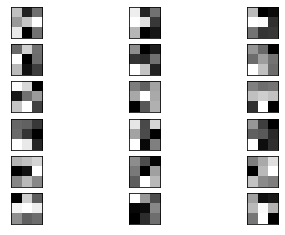

In [84]:
# cargamos los pesos de la primera capa escondida
filters, biases = model_best.layers[0].get_weights()
# normalizamos los valores de los filtros (0,1)
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# graficamos los primeros filtros
n_filters, ix = 6, 1
for i in range(n_filters):
# tomamos los filtros
    f = filters[:, :, :, i]
# graficamos cada canal separadamente
    for j in range(3):
        # subplot y axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
# graficamos cada filtro en escala de grises
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# graficamos la figura
pyplot.show()

En la primera capa de filtro lo que se puede visualizar es que los filtros aparentemente *observan* puntos o datos importantes a resaltar las imagenes, es decir, puntos focales, sin ningun patron aparente, ya que hay puntos oscuros no siempre conectados.

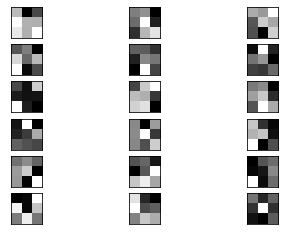

In [93]:
# cargamos los pesos de la segunda capa escondida
filters, biases = model_best.layers[2].get_weights()
# normalizamos los valores de los filtros (0,1)
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# graficamos los primeros filtros
n_filters, ix = 6, 1
for i in range(n_filters):
# tomamos los filtros
    f = filters[:, :, :, i]
# graficamos cada canal separadamente
    for j in range(3):
        # subplot y axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
# graficamos cada filtro en escala de grises
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# graficamos la figura
pyplot.show()

En la segunda capa de filtro lo que se puede visualizar es que los filtros aparentemente *observan* ya patrones vercticales y horizontales,es decir: se observan puntos oscuros (con informacion importante) cerca de otros puntos oscuros tanto vertical como horizontalmente.

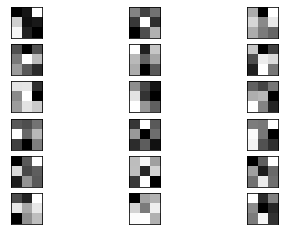

In [94]:
# cargamos los pesos de la tercera capa escondida
filters, biases = model_best.layers[4].get_weights()
# normalizamos los valores de los filtros (0,1)
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# graficamos los primeros filtros
n_filters, ix = 6, 1
for i in range(n_filters):
# tomamos los filtros
    f = filters[:, :, :, i]
# graficamos cada canal separadamente
    for j in range(3):
        # subplot y axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
# graficamos cada filtro en escala de grises
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# graficamos la figura
pyplot.show()

En la tercera capa de filtro lo que se puede visualizar es que los filtros aparentemente *observan* ya patrones diagonales,es decir: se observan puntos oscuros (con informacion importante) cerca de otros puntos oscuros diagonalmente.

## 2. Caso aplicado

Ahora probemos nuestro modelo sobre la imagen completa de prueba del paramo ``IMG_3451.JPG``.


In [73]:
import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
# load the image
img = load_img('IMG_3451.jpg')
print(type(img))
# convert to numpy array
img_array = img_to_array(img)
print(img_array.dtype)
print(img_array.shape)
# convert back to image
img_pil = array_to_img(img_array)
print(type(img))

<class 'PIL.JpegImagePlugin.JpegImageFile'>
float32
(3000, 4000, 3)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


### Red Convolucional

In [92]:
# red sencilla 5 neuronas
model_best = load_model('Best_Model_CNN_Conv.tf')

model_best.summary()

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_222 (Conv2D)          (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d_222 (MaxPoolin (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_223 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_223 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_224 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_224 (MaxPoolin (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_74 (Flatten)         (None, 3136)            

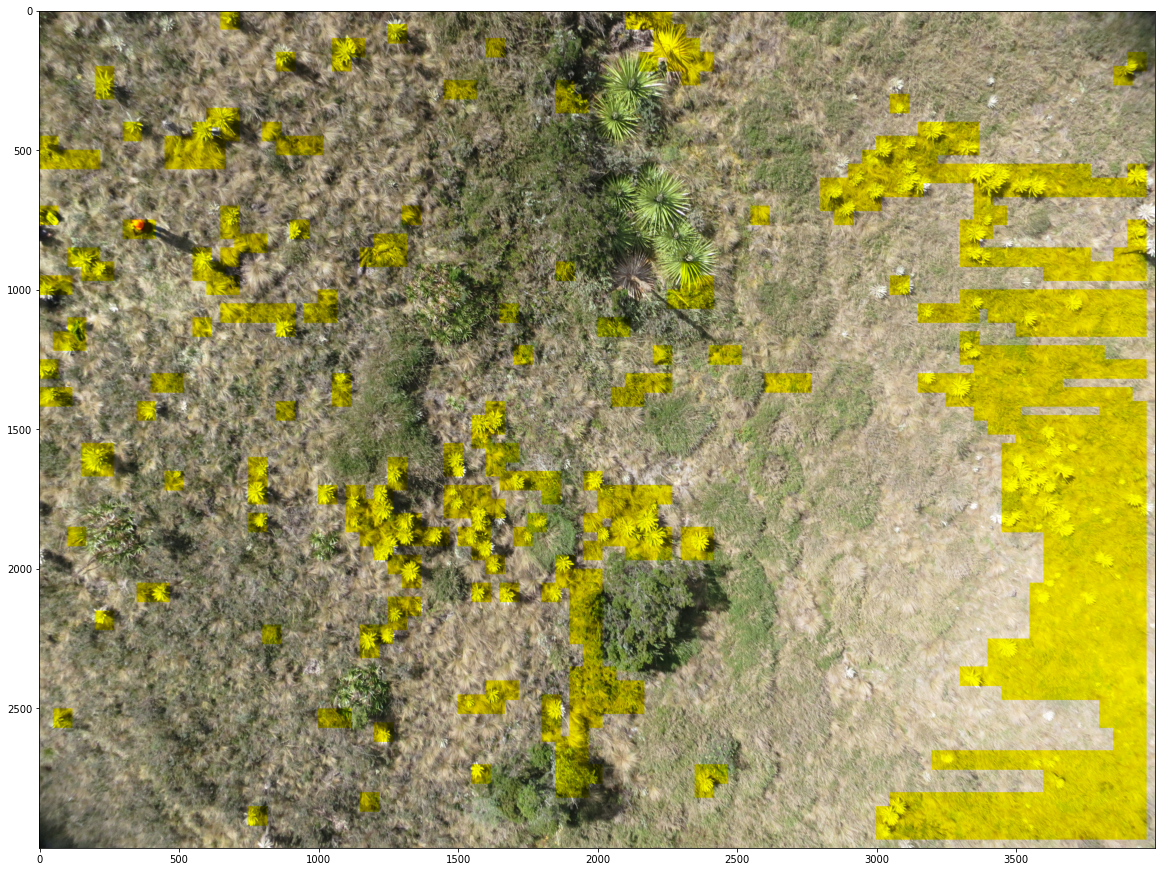

In [82]:
# Lo pasamos por nuestra imagen de prueba
x = np.array(img)
x2 = x

ni = x.shape[0]-50
mi = x.shape[1]-50

f1=0
f2=70
for i in range(1,ni,50):
    c1=0
    c2=70
    for j in range(1,mi,50):
        subi=x[f1:f2,c1:c2,]/255.
        subi2=np.expand_dims(subi,0)
        Y_preds = model_best.predict(subi2)
        pred_P = (Y_preds > 0.5)
        if(pred_P==1):
            x2[f1:f2,c1:c2,2]=0
        c1=c1+50
        c2=c2+50
    f1=f1+50
    f2=f2+50
        
plt.figure(figsize = (20,20))
plt.imshow(x2)


Lectura avanzada sobre métodos de optimización en redes profundas: https://openreview.net/pdf?id=ryQu7f-RZ
http://www.cs.utoronto.ca/~ilya/pubs/2013/1051_2.pdf
        